# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [1]:
import pandas as pd
from decimal import Decimal

from matplotlib import pyplot as plt

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker, DataFrameMetricsAnalyser

# Analysis utils
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [3]:
from src.Logger import Logger
from config.project_config import get_examples_path

# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_path = get_examples_path("Lateness_with__w_first", as_string= True)

# Simulation
simulation = ProductionSimulation(shift_length= 1440, sigma = 0.2)

# Logger
logger = Logger(log_file = f"{examples_path}/experiment_logger.log")

In [4]:
jobs = JobQuery.get_by_source_name_and_max_bottleneck_utilization(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization=Decimal("0.85"),
)

jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
...,...,...,...,...,...
7646,01-08500-7646,01-07,577068,577440,579349
7647,01-08500-7647,01-06,577077,577440,578784
7648,01-08500-7648,01-08,577128,577440,578982


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [7]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,None,31,None,0,1440,2746
1,01-08500-0000,01-07,1,M00,None,86,None,0,1440,2746
2,01-08500-0000,01-07,2,M01,None,46,None,0,1440,2746
3,01-08500-0000,01-07,3,M05,None,74,None,0,1440,2746
4,01-08500-0000,01-07,4,M04,None,32,None,0,1440,2746
5,01-08500-0000,01-07,5,M06,None,88,None,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,None,69,None,1437,1440,3089
155,01-08500-0015,01-01,5,M01,None,28,None,1437,1440,3089
156,01-08500-0015,01-01,6,M06,None,46,None,1437,1440,3089


In [8]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
6,01-08500-0006,01-00,753,1440,3570
7,01-08500-0007,01-03,896,1440,3379
8,01-08500-0008,01-09,962,1440,2689
9,01-08500-0009,01-08,979,1440,3402


### Scheduling

In [9]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start,
    logger = logger
)

In [10]:
solver.build_model__absolute_lateness__first_operation_earliness__start_deviation__minimization(
    previous_schedule_jobs_collection= None,
    active_jobs_collection= None,
    w_t= 3, w_e = 1, w_first= 1,
    duration_buffer_factor= 2.5
)

solver.log_model_info()

2025-08-17 16:59:13 INFO: Model weights: w_t = 3, w_e = 1, w_first = 1, w_dev = 0
2025-08-17 16:59:13 INFO: Model info ---------------
2025-08-17 16:59:13 INFO: Number of preparable operations: 160
2025-08-17 16:59:13 INFO: Number of previous operations  : 0
2025-08-17 16:59:13 INFO: Number of active operation     : 0
2025-08-17 16:59:13 INFO: Number of variables            : 368
2025-08-17 16:59:13 INFO: Number of constraints          : 378


In [11]:
solver.solve_model(
    log_file= f"{examples_path}/cp_solver_01_init.log",
    gap_limit= 0.00,
    time_limit= max_time
)
solver.log_solver_info()

2025-08-17 16:59:13 INFO: Solver info --------------
2025-08-17 16:59:13 INFO: Status              : OPTIMAL
2025-08-17 16:59:13 INFO: Objective value     : 0.0
2025-08-17 16:59:13 INFO: Best objective bound: 0.0
2025-08-17 16:59:13 INFO: Number of branches  : 4
2025-08-17 16:59:13 INFO: Wall time           : 0.03
2025-08-17 16:59:13 INFO: Tardiness cost      : 0
2025-08-17 16:59:13 INFO: Earliness cost      : 0
2025-08-17 16:59:13 INFO: Deviation cost      : 0


In [12]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440,31,1471,0,1440,2746
1,01-08500-0000,01-07,1,M00,1471,86,1557,0,1440,2746
2,01-08500-0000,01-07,2,M01,1616,46,1662,0,1440,2746
3,01-08500-0000,01-07,3,M05,1662,74,1736,0,1440,2746
4,01-08500-0000,01-07,4,M04,1736,32,1768,0,1440,2746
5,01-08500-0000,01-07,5,M06,1768,88,1856,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,2207,69,2276,1437,1440,3089
155,01-08500-0015,01-01,5,M01,2276,28,2304,1437,1440,3089
156,01-08500-0015,01-01,6,M06,2304,46,2350,1437,1440,3089


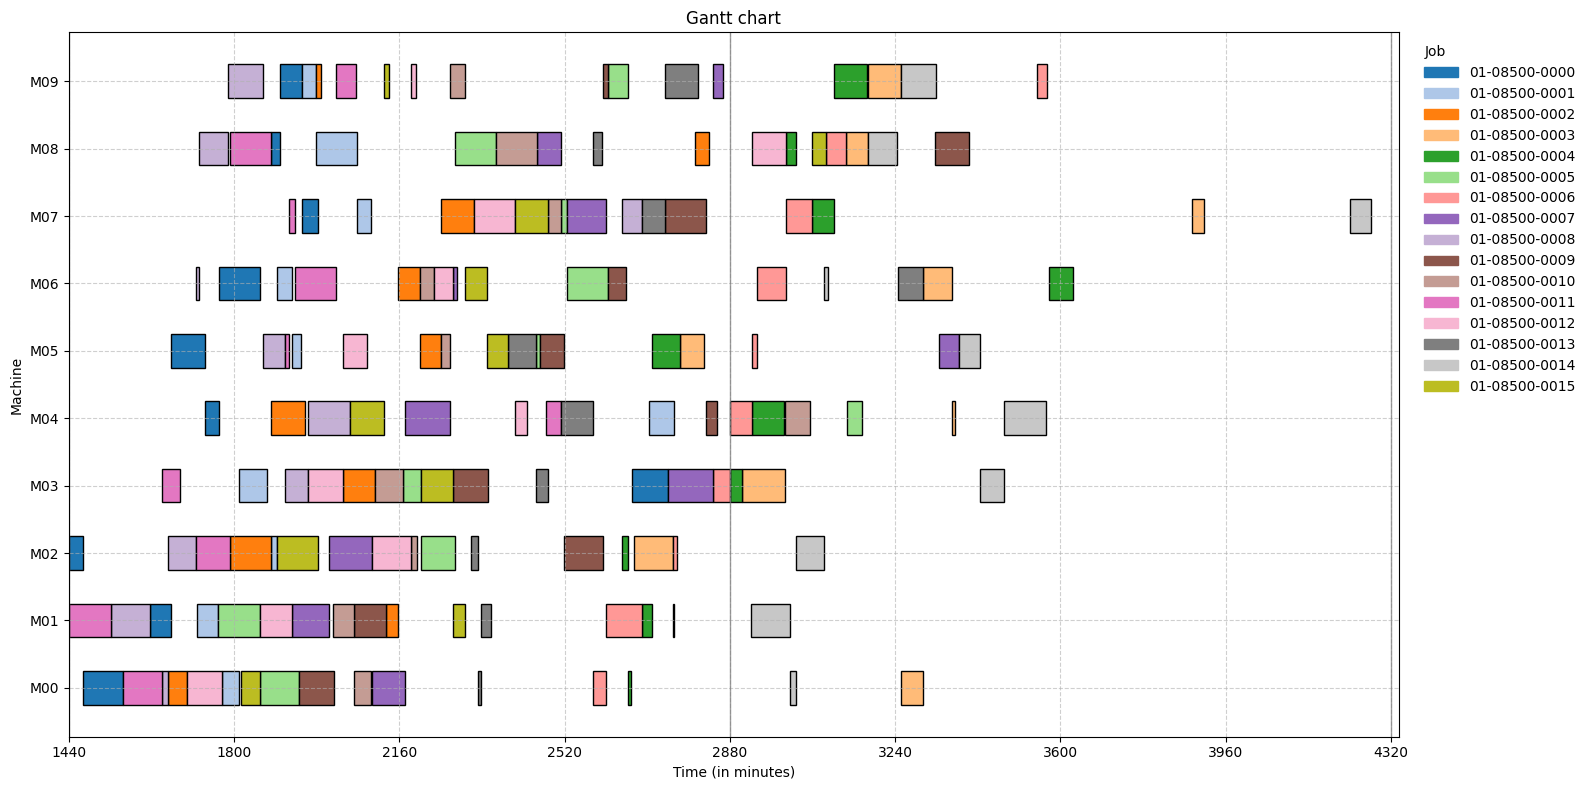

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [13]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)


In [14]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Due Date,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-08500-0000,01-07,9,2746,0,1440,2746,539,1306,0,0,0
1,01-08500-0001,01-06,9,2759,53,1440,2759,416,1319,0,0,0
2,01-08500-0002,01-01,9,2835,125,1440,2835,510,1395,0,0,0
3,01-08500-0003,01-05,9,3912,174,1440,3912,496,2472,0,0,0
4,01-08500-0004,01-04,9,3628,219,1440,3628,393,2188,0,0,0
5,01-08500-0005,01-02,9,3168,443,1440,3168,568,1728,0,0,0
6,01-08500-0006,01-00,9,3570,753,1440,3570,395,2130,0,0,0
7,01-08500-0007,01-03,9,3379,896,1440,3379,655,1939,0,0,0
8,01-08500-0008,01-09,9,2689,962,1440,2689,540,1249,0,0,0
9,01-08500-0009,01-08,9,3402,979,1440,3402,597,1962,0,0,0


In [15]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,16,0,0,0


In [16]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,16,0,0,0


### Simulation

In [17]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

[Day 1 00:00:00] Job 01-08500-0000 started on M02
[Day 1 00:00:00] Job 01-08500-0011 started on M01
[Day 1 00:53:00] Job 01-08500-0000 finished on M02 (after 53 minutes)
[Day 1 00:53:00] Job 01-08500-0000 started on M00
[Day 1 01:49:00] Job 01-08500-0011 finished on M01 (after 109 minutes)
[Day 1 01:49:00] Job 01-08500-0008 started on M01
[Day 1 02:27:00] Job 01-08500-0000 finished on M00 (after 94 minutes)
[Day 1 02:27:00] Job 01-08500-0011 started on M00
[Day 1 03:26:00] Job 01-08500-0011 finished on M00 (after 59 minutes)
[Day 1 03:26:00] Job 01-08500-0011 started on M03
[Day 1 03:35:00] Job 01-08500-0002 started on M00
[Day 1 04:02:00] Job 01-08500-0008 finished on M01 (after 133 minutes)
[Day 1 04:02:00] Job 01-08500-0000 started on M01
[Day 1 04:20:00] Job 01-08500-0011 finished on M03 (after 54 minutes)
[Day 1 04:31:00] Job 01-08500-0002 finished on M00 (after 56 minutes)
[Day 1 04:31:00] Job 01-08500-0008 started on M00
[Day 1 04:36:00] Job 01-08500-0011 started on M02
[Day 1 0

In [18]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440.0,53.0,1493.0,0,1440,2746
1,01-08500-0000,01-07,1,M00,1493.0,94.0,1587.0,0,1440,2746
2,01-08500-0000,01-07,2,M01,1682.0,47.0,1729.0,0,1440,2746
3,01-08500-0000,01-07,3,M05,1729.0,81.0,1810.0,0,1440,2746
4,01-08500-0000,01-07,4,M04,1810.0,21.0,1831.0,0,1440,2746
5,01-08500-0000,01-07,5,M06,1831.0,82.0,1913.0,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
114,01-08500-0004,01-04,1,M00,2663.0,7.0,2670.0,219,1440,3628
115,01-08500-0004,01-04,2,M01,2689.0,20.0,2709.0,219,1440,3628
116,01-08500-0004,01-04,3,M05,2711.0,54.0,2765.0,219,1440,3628


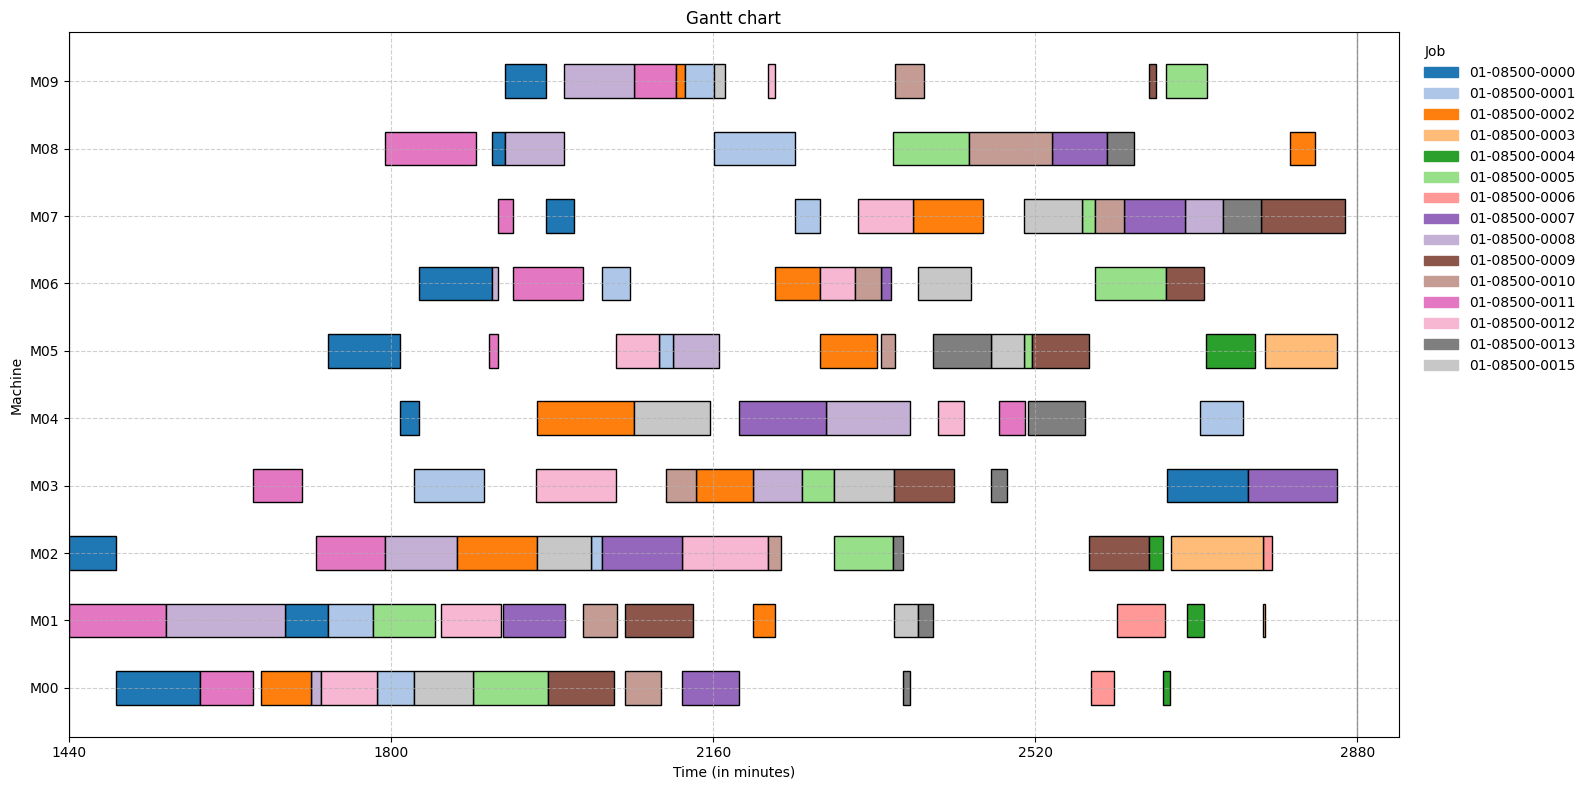

In [19]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution, perspective="Machine")
plt.show()

In [20]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0013,01-04,8,M09,2772.0,109.0,2881.0,1178,1440,3300
1,01-08500-0006,01-00,3,M03,2857.0,48.0,2905.0,753,1440,3570
2,01-08500-0009,01-08,8,M04,2866.0,20.0,2886.0,979,1440,3402


In [21]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2906,95,3001,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133,48,3181,174,1440,3912
2,01-08500-0003,01-05,5,M09,3181,72,3253,174,1440,3912
3,01-08500-0003,01-05,6,M00,3253,47,3300,174,1440,3912
4,01-08500-0003,01-05,7,M06,3300,65,3365,174,1440,3912
5,01-08500-0003,01-05,8,M04,3365,6,3371,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
31,01-08500-0014,01-09,5,M09,3253,76,3329,1210,1440,4277
32,01-08500-0014,01-09,6,M05,3379,47,3426,1210,1440,4277
33,01-08500-0014,01-09,7,M03,3426,52,3478,1210,1440,4277


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [22]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [23]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [24]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0016,01-07,0,M02,None,31,None,1504,2880,4447
1,01-08500-0016,01-07,1,M00,None,86,None,1504,2880,4447
2,01-08500-0016,01-07,2,M01,None,46,None,1504,2880,4447
3,01-08500-0016,01-07,3,M05,None,74,None,1504,2880,4447
4,01-08500-0016,01-07,4,M04,None,32,None,1504,2880,4447
5,01-08500-0016,01-07,5,M06,None,88,None,1504,2880,4447
...,...,...,...,...,...,...,...,...,...,...
204,01-08500-0036,01-03,4,M06,None,9,None,2811,2880,4882
205,01-08500-0036,01-03,5,M08,None,52,None,2811,2880,4882
206,01-08500-0036,01-03,6,M07,None,85,None,2811,2880,4882


In [25]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2906.0,95,3001.0,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133.0,48,3181.0,174,1440,3912
2,01-08500-0003,01-05,5,M09,3181.0,72,3253.0,174,1440,3912
3,01-08500-0003,01-05,6,M00,3253.0,47,3300.0,174,1440,3912
4,01-08500-0003,01-05,7,M06,3300.0,65,3365.0,174,1440,3912
5,01-08500-0003,01-05,8,M04,3365.0,6,3371.0,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
241,01-08500-0036,01-03,4,M06,NaN,9,NaN,2811,2880,4882
242,01-08500-0036,01-03,5,M08,NaN,52,NaN,2811,2880,4882
243,01-08500-0036,01-03,6,M07,NaN,85,NaN,2811,2880,4882


### Scheduling (Rescheduling)

In [26]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [27]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start,
    logger = logger
)

solver.build_model__absolute_lateness__first_operation_earliness__start_deviation__minimization(
    previous_schedule_jobs_collection= None,         # simple scheduling
    active_jobs_collection= active_job_ops_collection,
    w_t= 3, w_e = 1, w_first= 1,
    duration_buffer_factor= 2.5
)
solver.log_model_info()

solver.solve_model(
    log_file= f"{examples_path}/cp_solver_02_simple.log",
    gap_limit= 0.00,
    time_limit= max_time
)
solver.log_solver_info()


2025-08-17 16:59:15 INFO: Model weights: w_t = 3, w_e = 1, w_first = 1, w_dev = 0
2025-08-17 16:59:15 INFO: Model info ---------------
2025-08-17 16:59:15 INFO: Number of preparable operations: 247
2025-08-17 16:59:15 INFO: Number of previous operations  : 0
2025-08-17 16:59:15 INFO: Number of active operation     : 3
2025-08-17 16:59:15 INFO: Number of variables            : 580
2025-08-17 16:59:15 INFO: Number of constraints          : 593
2025-08-17 16:59:15 INFO: Solver info --------------
2025-08-17 16:59:15 INFO: Status              : OPTIMAL
2025-08-17 16:59:15 INFO: Objective value     : 22.0
2025-08-17 16:59:15 INFO: Best objective bound: 22.0
2025-08-17 16:59:15 INFO: Number of branches  : 113
2025-08-17 16:59:15 INFO: Wall time           : 0.16
2025-08-17 16:59:15 INFO: Tardiness cost      : 0
2025-08-17 16:59:15 INFO: Earliness cost      : 22
2025-08-17 16:59:15 INFO: Deviation cost      : 0


In [28]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_02_simple.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2905,95,3000,174,1440,3912
1,01-08500-0003,01-05,4,M08,3003,48,3051,174,1440,3912
2,01-08500-0003,01-05,5,M09,3202,72,3274,174,1440,3912
3,01-08500-0003,01-05,6,M00,3274,47,3321,174,1440,3912
4,01-08500-0003,01-05,7,M06,3388,65,3453,174,1440,3912
5,01-08500-0003,01-05,8,M04,3453,6,3459,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
241,01-08500-0036,01-03,4,M06,4157,9,4166,2811,2880,4882
242,01-08500-0036,01-03,5,M08,4172,52,4224,2811,2880,4882
243,01-08500-0036,01-03,6,M07,4277,85,4362,2811,2880,4882


In [29]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 8 (over 36 shared operations)
Mean Kendall Tau: 0.84


In [30]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,31,0,0,0


### b) with 'start' deviation penalty

In [31]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start,
    logger = logger
)

solver.build_model__absolute_lateness__first_operation_earliness__start_deviation__minimization(
    previous_schedule_jobs_collection= previous_schedule_jobs_collection,
    active_jobs_collection= active_job_ops_collection,
    w_t= 3, w_e = 1, w_first= 1, w_dev = 4,
    duration_buffer_factor= 2.5
)
solver.log_model_info()

solver.solve_model(
    log_file= f"{examples_path}/cp_solver_02_dev.log",
    gap_limit= 0.00,
    time_limit= max_time
)
solver.log_solver_info()

2025-08-17 16:59:15 INFO: Model weights: w_t = 3, w_e = 1, w_first = 1, w_dev = 4
2025-08-17 16:59:15 INFO: Model info ---------------
2025-08-17 16:59:15 INFO: Number of preparable operations: 247
2025-08-17 16:59:15 INFO: Number of previous operations  : 160
2025-08-17 16:59:15 INFO: Number of active operation     : 3
2025-08-17 16:59:15 INFO: Number of variables            : 617
2025-08-17 16:59:15 INFO: Number of constraints          : 630
2025-08-17 16:59:17 INFO: Solver info --------------
2025-08-17 16:59:17 INFO: Status              : OPTIMAL
2025-08-17 16:59:17 INFO: Objective value     : 1771.0
2025-08-17 16:59:17 INFO: Best objective bound: 1771.0
2025-08-17 16:59:17 INFO: Number of branches  : 104
2025-08-17 16:59:17 INFO: Wall time           : 1.28
2025-08-17 16:59:17 INFO: Tardiness cost      : 69
2025-08-17 16:59:17 INFO: Earliness cost      : 22
2025-08-17 16:59:17 INFO: Deviation cost      : 1680


In [32]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_02_devpen.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2931,95,3026,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133,48,3181,174,1440,3912
2,01-08500-0003,01-05,5,M09,3204,72,3276,174,1440,3912
3,01-08500-0003,01-05,6,M00,3276,47,3323,174,1440,3912
4,01-08500-0003,01-05,7,M06,3323,65,3388,174,1440,3912
5,01-08500-0003,01-05,8,M04,3388,6,3394,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
241,01-08500-0036,01-03,4,M06,3762,9,3771,2811,2880,4882
242,01-08500-0036,01-03,5,M08,3799,52,3851,2811,2880,4882
243,01-08500-0036,01-03,6,M07,4514,85,4599,2811,2880,4882


In [33]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M00,"[01-08500-0014, 01-08500-0003]","[01-08500-0014, 01-08500-0003]",0,1.0
M01,[01-08500-0014],[01-08500-0014],0,1.0
M02,[01-08500-0014],[01-08500-0014],0,1.0
M03,"[01-08500-0004, 01-08500-0003, 01-08500-0014]","[01-08500-0004, 01-08500-0003, 01-08500-0014]",0,1.0
M04,"[01-08500-0006, 01-08500-0004, 01-08500-0010, ...","[01-08500-0006, 01-08500-0004, 01-08500-0010, ...",0,1.0
M05,"[01-08500-0006, 01-08500-0007, 01-08500-0014]","[01-08500-0006, 01-08500-0007, 01-08500-0014]",0,1.0
M06,"[01-08500-0006, 01-08500-0014, 01-08500-0013, ...","[01-08500-0006, 01-08500-0014, 01-08500-0013, ...",0,1.0
M07,"[01-08500-0006, 01-08500-0004, 01-08500-0003, ...","[01-08500-0006, 01-08500-0004, 01-08500-0003, ...",0,1.0
M08,"[01-08500-0012, 01-08500-0004, 01-08500-0015, ...","[01-08500-0012, 01-08500-0004, 01-08500-0015, ...",0,1.0


In [34]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 0 (over 36 shared operations)
Mean Kendall Tau: 1.00


In [35]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,30,1,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

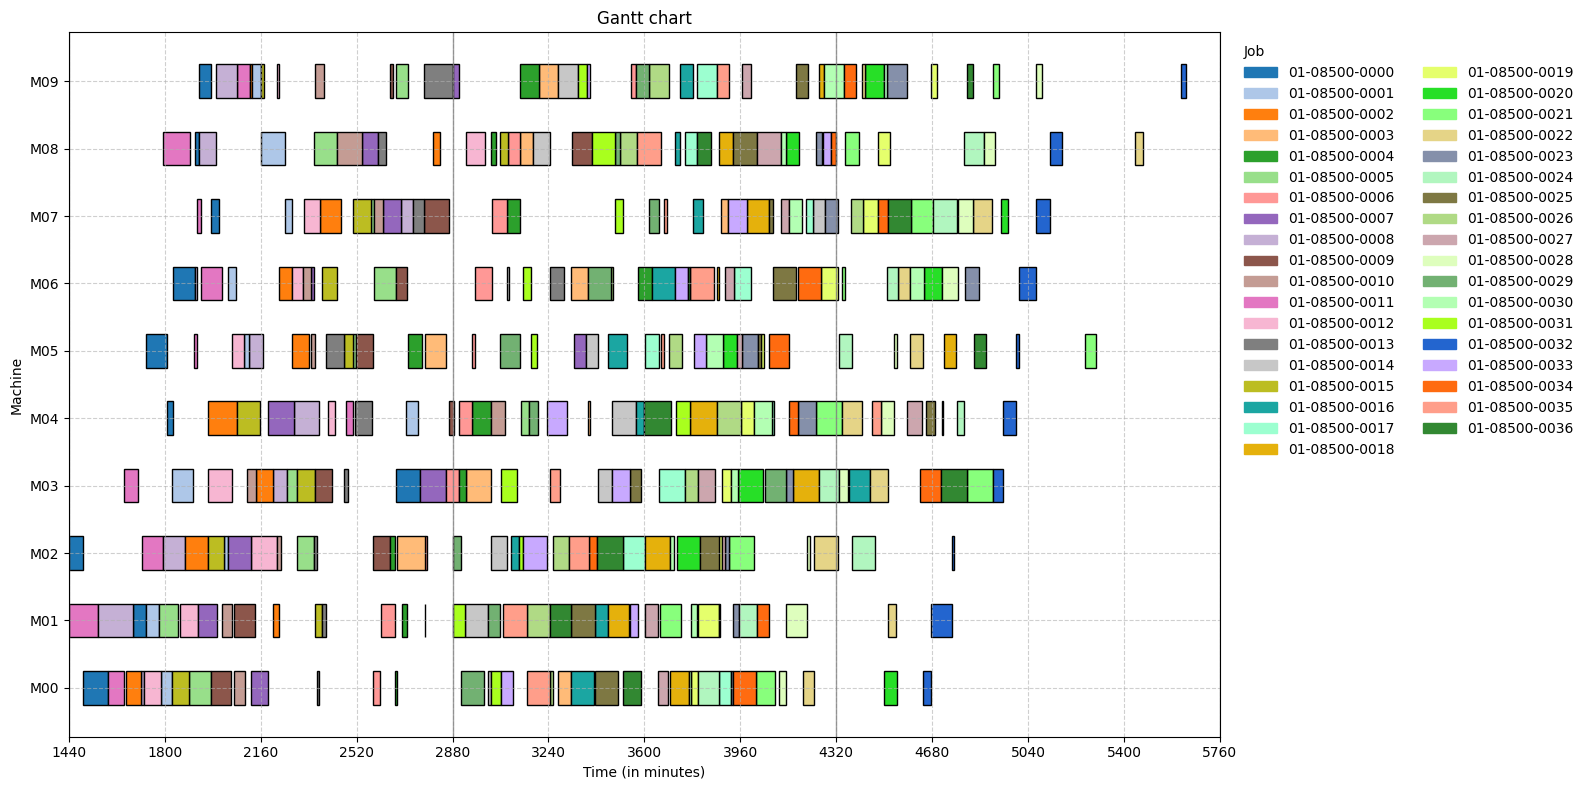

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [36]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)

### Simulation

In [37]:
simulation.run(schedule_collection=schedule_jobs_collection, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job 01-08500-0013, Operation 8 resumed on M09 with 01 minute left)
[Day 2 00:00:00] Job 01-08500-0006, Operation 3 resumed on M03 with 25 minutes left)
[Day 2 00:00:00] Job 01-08500-0009, Operation 8 resumed on M04 with 06 minutes left)
[Day 2 00:00:00] Job 01-08500-0029 started on M02
[Day 2 00:00:00] Job 01-08500-0031 started on M01
[Day 2 00:01:00] Job 01-08500-0013 finished on M09 (after 01 minute)
[Day 2 00:01:00] Job 01-08500-0007 started on M09
[Day 2 00:06:00] Job 01-08500-0009 finished on M04 (after 06 minutes)
[Day 2 00:22:00] Job 01-08500-0007 finished on M09 (after 21 minutes)
[Day 2 00:25:00] Job 01-08500-0006 finished on M03 (after 25 minutes)
[Day 2 00:25:00] Job 01-08500-0006 started on M04
[Day 2 00:25:00] Job 01-08500-0004 started on M03
[Day 2 00:28:00] Job 01-08500-0029 finished on M02 (after 28 minutes)
[Day 2 00:32:00] Job 01-08500-0029 started on M00
[Day 2 00:48:00] Job 01-08500-0004 finished on M03 (after 23 minutes)
[Day 2 00:49:00] Job 01-085

In [38]:
finished_job_ops_collection2 = simulation.get_finished_operation_collection()
df_execution2 = finished_job_ops_collection2.to_operations_dataframe()

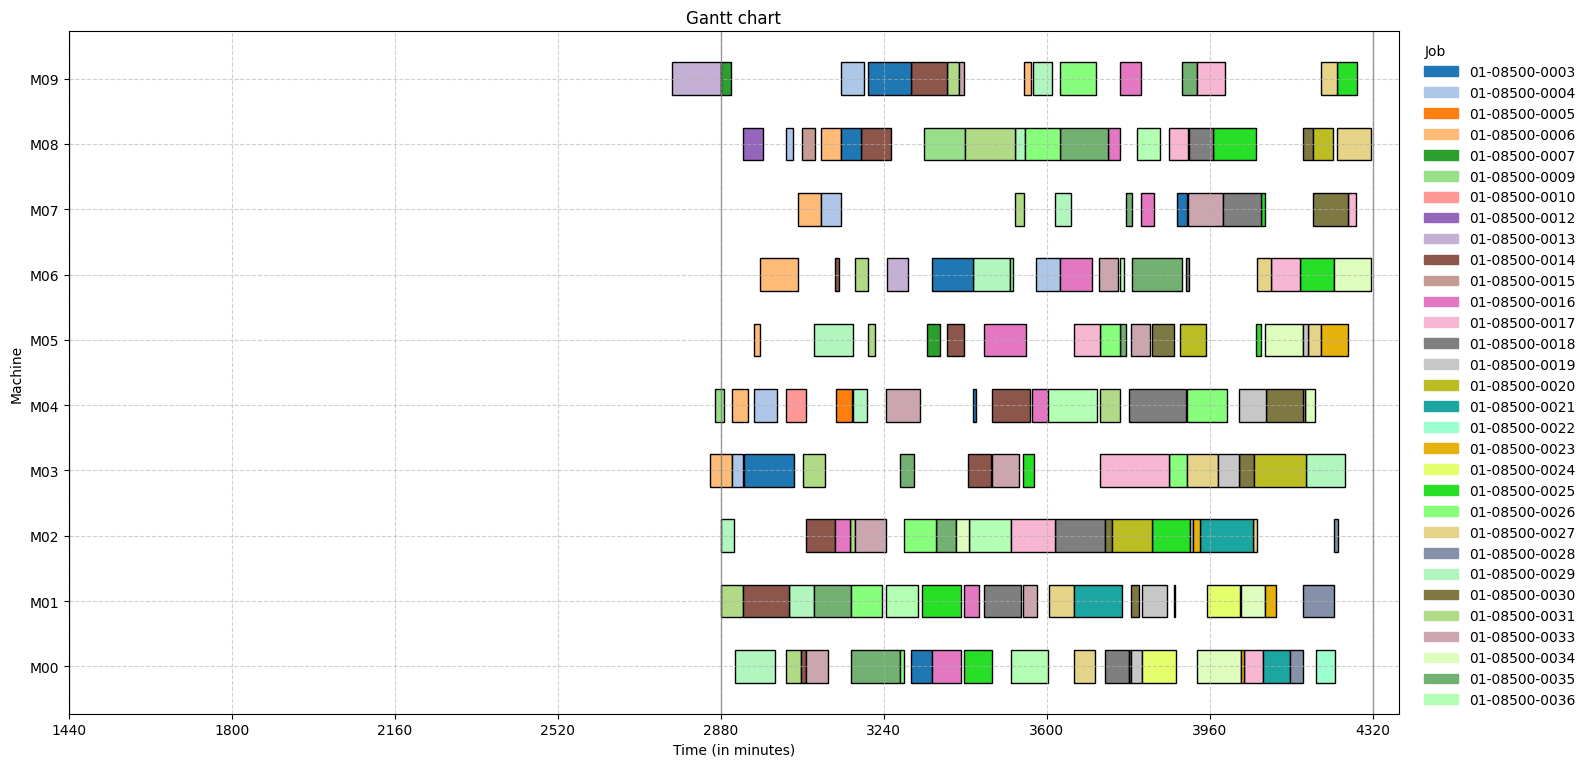

In [39]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution2, perspective="Machine")
plt.show()

#### Check the conditions of the combined data set from the two simulation data sets

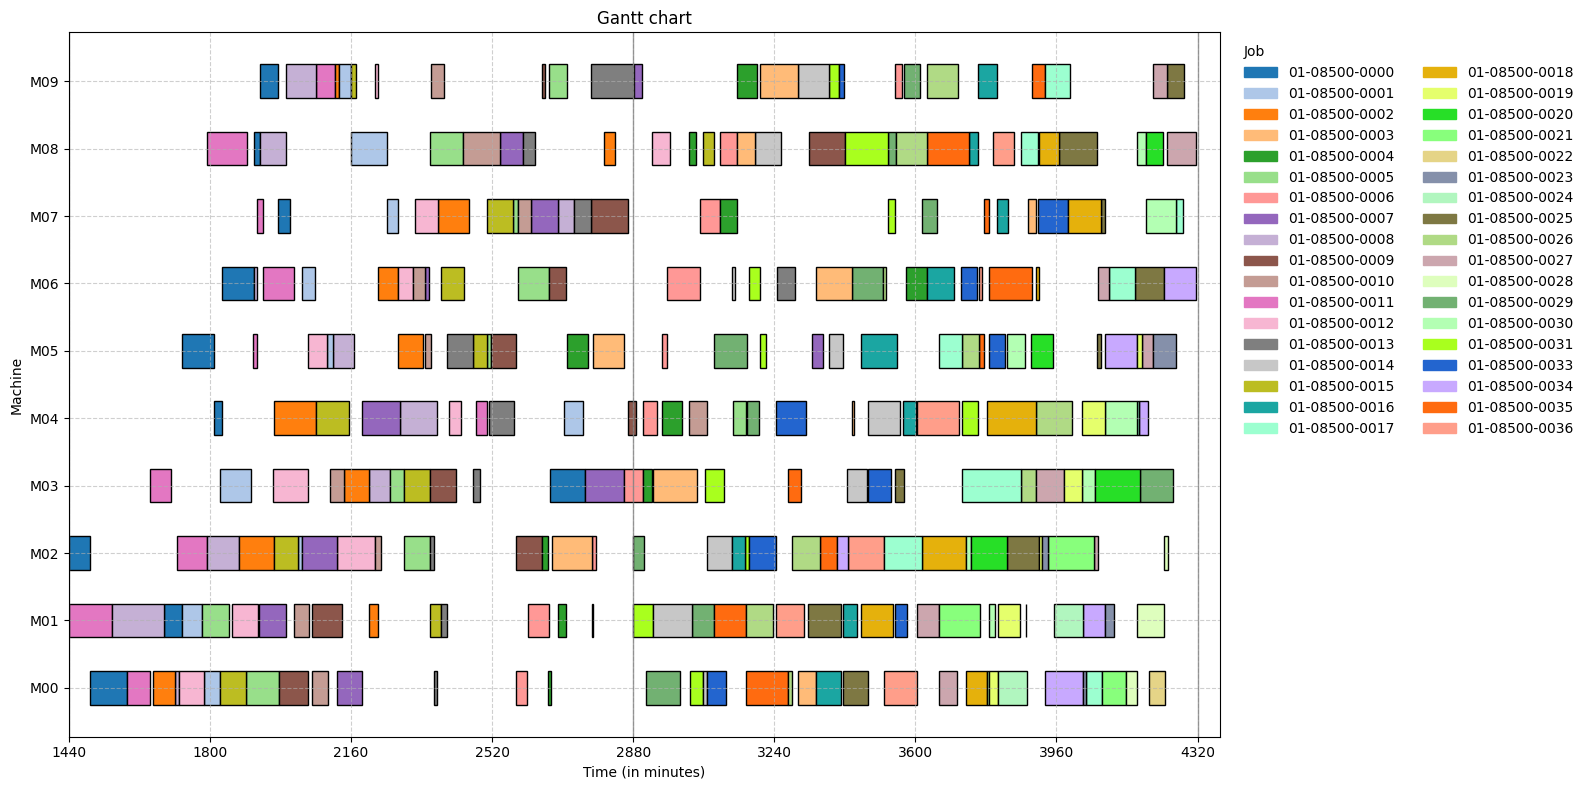

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [40]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)